In [3]:
#Qiming Sun
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [4]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [5]:
y.shape, tx.shape

((10000,), (10000, 2))

In [6]:

print(y)
print(tx)
print(x)

[109.81967768  73.68895452  96.58434842 ...  58.32779473  74.38901745
  51.59669261]
[[ 1.          1.94406149]
 [ 1.          0.62753668]
 [ 1.          2.01244346]
 ...
 [ 1.         -0.64968792]
 [ 1.          0.69312469]
 [ 1.         -1.14970831]]
[ 1.94406149  0.62753668  2.01244346 ... -0.64968792  0.69312469
 -1.14970831]


### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

In [7]:


def compute_loss(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    # y = y.reshape(len(y),1)
    # if w.ndim == 1:
    #     w = w.reshape(len(w),1)
    loss = np.mean((y - tx.dot(w))**2)/2
    return loss
    # ***************************************************
    raise NotImplementedError

In [8]:
# test
w = np.array([1,2]).T
compute_loss(y,tx,w)
# print(tx.dot(w))
# print(tx@w)
# print(tx*w)
# print(np.multiply(tx,w))
y.shape

(10000,)

# 2. Grid Search

Fill in the function `grid_search()` below:

In [9]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    W = np.array(np.meshgrid(grid_w0, grid_w1)).transpose(1,0,2)
    y = y.reshape(len(y),1)
    losses = np.mean((y - tx.dot(W).reshape(len(tx),-1))**2, axis = 0).reshape(len(grid_w0),-1)
    # losses = compute_loss(y,tx,W).reshape(len(grid_w0),-1)
    return losses/2
    # ***************************************************
    raise NotImplementedError
  

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678253, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.045 seconds


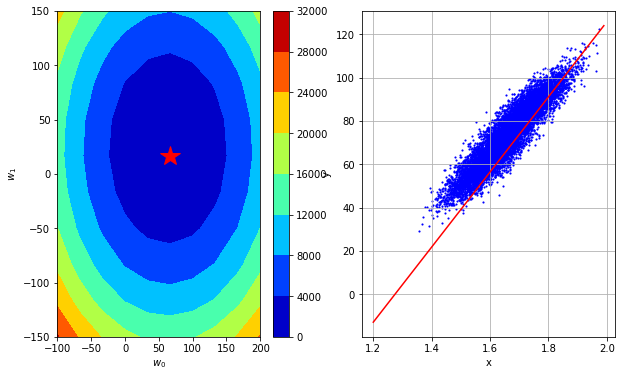

In [10]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [11]:
from matplotlib.pyplot import grid


def compute_gradient(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # y = y.reshape(len(y),-1)
    grid = -np.mean((y - tx.dot(w)).reshape(len(y),-1)*tx,axis=0)

    return grid
    # ***************************************************
    raise NotImplementedError

Please fill in the functions `gradient_descent` below:

In [12]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        loss = compute_loss(y,tx,w)
        grid = compute_gradient(y,tx,w)
        # ***************************************************
        # raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        w = w - gamma*grid
        # ***************************************************
        # raise NotImplementedError
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [13]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([50, 10])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=292.7434883040181, w0=52.32939220021051, w1=10.3479712434989
GD iter. 1/49: loss=240.0455442213324, w0=54.425845180399975, w1=10.661145362647916
GD iter. 2/49: loss=197.36020951435694, w0=56.312652862570495, w1=10.943002069882029
GD iter. 3/49: loss=162.78508840170676, w0=58.01077977652396, w1=11.196673106392728
GD iter. 4/49: loss=134.77924030046012, w0=59.539093999082084, w1=11.424977039252358
GD iter. 5/49: loss=112.09450333845028, w0=60.9145767993844, w1=11.630450578826025
GD iter. 6/49: loss=93.71986639922227, w0=62.152511319656476, w1=11.815376764442327
GD iter. 7/49: loss=78.83641047844763, w0=63.266652387901345, w1=11.981810331496998
GD iter. 8/49: loss=66.7808111826202, w0=64.26937934932172, w1=12.131600541846202
GD iter. 9/49: loss=57.015775752999986, w0=65.17183361460008, w1=12.266411731160487
GD iter. 10/49: loss=49.106097055007545, w0=65.9840424533506, w1=12.38774180154334
GD iter. 11/49: loss=42.69925730963363, w0=66.71503040822606, w1=12.4969388648879

In [14]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [15]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    # raise NotImplementedError
    grid = -np.mean((y - tx.dot(w)).reshape(len(y),-1)*tx,axis=0)
    return grid


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        # raise NotImplementedError

        index = np.random.randint(0,len(y),batch_size)# select randomly batch_size element from y to compute loss and grid
        ys,txs = y[index],tx[index] #batch from y
        loss = compute_loss(ys,txs,w)
        grid = compute_stoch_gradient(ys,txs,w)

        w = w - gamma*grid

        ws.append(w)
        losses.append(loss)

        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [16]:
batch_size = 10
index = np.random.randint(0,len(y),batch_size)
y[index].shape
stochastic_gradient_descent(y, tx, w_initial, batch_size, max_iters, gamma)

SGD iter. 0/49: loss=223.5743533174922, w0=52.083980500008664, w1=9.650016122432937
SGD iter. 1/49: loss=303.622048942763, w0=54.48964811435199, w1=10.431132600207924
SGD iter. 2/49: loss=213.56737347054724, w0=56.43905923978726, w1=10.246872797106331
SGD iter. 3/49: loss=155.07427162720347, w0=58.070377041359244, w1=9.640693592296621
SGD iter. 4/49: loss=99.04187652752407, w0=59.26783484752961, w1=9.93031573876055
SGD iter. 5/49: loss=133.891306164201, w0=60.77285779179484, w1=10.915459161120049
SGD iter. 6/49: loss=76.93243639227562, w0=61.83877991379091, w1=11.315037563341617
SGD iter. 7/49: loss=105.82740973404722, w0=63.215986817831165, w1=11.353382632507728
SGD iter. 8/49: loss=107.2717077835191, w0=64.5430594154338, w1=11.81052642604242
SGD iter. 9/49: loss=79.20818375567623, w0=65.46842676483676, w1=12.179143296178765
SGD iter. 10/49: loss=48.07324512160052, w0=66.10764353268577, w1=12.412352453871046
SGD iter. 11/49: loss=29.550816156808388, w0=66.76814776260382, w1=12.6330168

([223.5743533174922,
  303.622048942763,
  213.56737347054724,
  155.07427162720347,
  99.04187652752407,
  133.891306164201,
  76.93243639227562,
  105.82740973404722,
  107.2717077835191,
  79.20818375567623,
  48.07324512160052,
  29.550816156808388,
  26.64181823498439,
  21.30313741688057,
  45.456181896959265,
  13.70052445454707,
  14.028511049303711,
  27.873902079152696,
  14.854640939476184,
  20.333464490473233,
  9.985598457930028,
  18.002140658854955,
  9.59406569294269,
  11.130941493679908,
  11.345271061266029,
  37.77965603451952,
  20.863945068311224,
  15.680904398273222,
  12.401192228457976,
  10.939666880857013,
  34.58161213368156,
  9.1068216116899,
  12.286471263857013,
  15.53528044080532,
  24.64551117710723,
  17.707838099502904,
  27.49587015130836,
  24.58007248755414,
  12.036746900705115,
  13.88890463007752,
  14.648584809482031,
  14.896031450373608,
  19.076539186031585,
  12.30644832253643,
  11.12337753577616,
  17.373511464275527,
  19.09830547688

In [17]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2025.1193340043885, w0=6.364148543213599, w1=-0.9493434738837938
SGD iter. 1/49: loss=2872.3374094146893, w0=13.94351185343259, w1=0.23804556869924198
SGD iter. 2/49: loss=1982.1779744649361, w0=20.23982501982598, w1=0.33081803745124305
SGD iter. 3/49: loss=1167.805395712214, w0=25.072640753354857, w1=1.9839655807805807
SGD iter. 4/49: loss=1289.6035608354434, w0=30.151230244218326, w1=4.8376653338381095
SGD iter. 5/49: loss=685.5192911871108, w0=33.85398406046674, w1=3.160930348802527
SGD iter. 6/49: loss=356.4889934700998, w0=36.52414882493391, w1=2.0209554771941827
SGD iter. 7/49: loss=1233.5362027757344, w0=41.4911120878859, w1=5.373061073653652
SGD iter. 8/49: loss=211.1616686800254, w0=43.546162786433385, w1=4.337592823957799
SGD iter. 9/49: loss=94.22841996857332, w0=44.91895861953147, w1=2.127944637290103
SGD iter. 10/49: loss=206.40724224476585, w0=46.95074228047949, w1=0.857319519388478
SGD iter. 11/49: loss=743.2224650791757, w0=50.80618639258687, w1=5.3

In [18]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [175]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
# raise NotImplementedError
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [176]:
y.shape, tx.shape

((202,), (202, 2))

In [177]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
# ***************************************************
# raise NotImplementedError
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.84746409844842, w1=7.724426406192425
GD iter. 1/49: loss=318.2821247015965, w0=67.40170332798297, w1=10.041754328050116
GD iter. 2/49: loss=88.6423556165128, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.97477639885521, w0=73.46785662750146, w1=10.9455122175746
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631798
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.032481534481912
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536945
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003895
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.034889001593541
GD iter

In [178]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [40]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    # raise NotImplementedError
    res = np.zeros((tx.shape[0],tx.shape[1]))
    res[(y-tx.dot(w))>=0] = -tx[(y-tx.dot(w))>=0]
    res[(y-tx.dot(w))< 0] = tx[(y-tx.dot(w))<0]
    grid = np.mean(res,axis=0)
    return grid

In [41]:
res = np.zeros((tx.shape[0],tx.shape[1]))
res.shape
res[(y-tx.dot(w))>=0] = -tx[(y-tx.dot(w))>=0]
res[(y-tx.dot(w))< 0] = tx[(y-tx.dot(w))<0]
grid = np.mean(res,axis=0)
grid.shape

(2,)

In [48]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        # raise NotImplementedError
        loss = np.mean(np.abs(y-tx.dot(w)))
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        # raise NotImplementedError
        grid = compute_subgradient_mae(y,tx,w)
        w = w - gamma*grid
        
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [49]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=73.29392200210518, w0=0.7, w1=-1.5529755259535704e-15
SubGD iter. 1/499: loss=72.59392200210517, w0=1.4, w1=-3.1059510519071408e-15
SubGD iter. 2/499: loss=71.89392200210517, w0=2.0999999999999996, w1=-4.658926577860711e-15
SubGD iter. 3/499: loss=71.19392200210518, w0=2.8, w1=-6.2119021038142816e-15
SubGD iter. 4/499: loss=70.49392200210517, w0=3.5, w1=-7.764877629767851e-15
SubGD iter. 5/499: loss=69.79392200210518, w0=4.2, w1=-9.317853155721422e-15
SubGD iter. 6/499: loss=69.09392200210519, w0=4.9, w1=-1.0870828681674993e-14
SubGD iter. 7/499: loss=68.39392200210517, w0=5.6000000000000005, w1=-1.2423804207628563e-14
SubGD iter. 8/499: loss=67.69392200210518, w0=6.300000000000001, w1=-1.3976779733582134e-14
SubGD iter. 9/499: loss=66.99392200210517, w0=7.000000000000001, w1=-1.5529755259535703e-14
SubGD iter. 10/499: loss=66.29392200210518, w0=7.700000000000001, w1=-1.7082730785489272e-14
SubGD iter. 11/499: loss=65.59392200210519, w0=8.4, w1=-1.86357063114428

In [50]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [51]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        # raise NotImplementedError
        index = np.random.randint(0,len(y),batch_size)# select randomly batch_size element from y to compute loss and grid
        ys,txs = y[index],tx[index] #batch from y
        loss = np.mean(np.abs(ys - txs.dot(w)))
        grid = compute_subgradient_mae(ys,txs,w)

        w = w - gamma*grid

        ws.append(w)
        losses.append(loss)
        
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [52]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=54.68080451840291, w0=0.7, w1=-0.973234543164873
SubSGD iter. 1/499: loss=64.74362394929184, w0=1.4, w1=-1.1345715060118011
SubSGD iter. 2/499: loss=63.66821090937238, w0=2.0999999999999996, w1=-1.0220638998251608
SubSGD iter. 3/499: loss=97.33633835427287, w0=2.8, w1=-0.18823569978986543
SubSGD iter. 4/499: loss=56.63704134326494, w0=3.5, w1=-1.1179676527046323
SubSGD iter. 5/499: loss=74.00328415863316, w0=4.2, w1=-0.536546308471064
SubSGD iter. 6/499: loss=84.16349225263784, w0=4.9, w1=-0.12433419066136314
SubSGD iter. 7/499: loss=68.32175335738535, w0=5.6000000000000005, w1=0.17391660618920896
SubSGD iter. 8/499: loss=96.5620809187256, w0=6.300000000000001, w1=1.283266140682362
SubSGD iter. 9/499: loss=69.13503132631334, w0=7.000000000000001, w1=1.257556227906302
SubSGD iter. 10/499: loss=82.19632043861243, w0=7.700000000000001, w1=2.254698127095801
SubSGD iter. 11/499: loss=67.37192026566956, w0=8.4, w1=2.873873659458016
SubSGD iter. 12/499: loss=85.296053

In [53]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>